<h1>Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines</h1>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [2]:
train = pd.read_csv('./data/training_set_features.csv', index_col='respondent_id')

In [3]:
test = pd.read_csv('./data/test_set_features.csv', index_col='respondent_id')

In [4]:
labels = pd.read_csv('./data/training_set_labels.csv', index_col='respondent_id')

### Imputation strategy

In [5]:
num_cols = train.select_dtypes('number').columns

In [6]:
str_cols = train.select_dtypes(include = 'object').columns
train[str_cols].head(2)

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe


In [9]:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [7]:
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier

In [13]:
# Impute train
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [14]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='missing')

In [15]:
# Impute test
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

In [16]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='missing')

### Train test split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

## Step Forward Selection


In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [21]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != float)[0]

In [22]:
cat_cols = X_train.select_dtypes('object').columns

In [25]:
cat_cols

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

In [26]:
ct = ColumnTransformer(
    [('ordinal', oe(), cat_cols)],
    remainder='passthrough')

In [27]:
all_cols = X_train.columns

### Feature selection using CatBoost for H1N1

In [28]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), #trained multiple times with different subsets of features 
           k_features=X_train.shape[1], #number of features to select
           forward=True, #forward= start with 0 features and keep adding, backward= start with all and keep removing
           floating=False, # doesn't allow features to be added and removed during the selection process 
           verbose=2, #0= no output, 1= print progress, 2= more detailed
           scoring='roc_auc',
           cv=5 #number of folds for cross-validation
           )

In [29]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warning

In [30]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7050372019814923, 0.708107924020672, 0.7061...",0.707174,"(28,)",0.005078,0.003951,0.001975
2,"(21, 28)","[0.7925673159437187, 0.7833433373349339, 0.783...",0.78679,"(21, 28)",0.008038,0.006254,0.003127
3,"(21, 26, 28)","[0.8313456200855761, 0.8251577226635334, 0.814...",0.825315,"(21, 26, 28)",0.00898,0.006987,0.003494
4,"(21, 26, 27, 28)","[0.847351505250716, 0.8445369637216589, 0.8370...",0.844031,"(21, 26, 27, 28)",0.007483,0.005822,0.002911
5,"(10, 21, 26, 27, 28)","[0.8566289917244658, 0.85181434275838, 0.84798...",0.853494,"(10, 21, 26, 27, 28)",0.008103,0.006304,0.003152
6,"(10, 21, 25, 26, 27, 28)","[0.8585297824636395, 0.8524235226005294, 0.849...",0.855619,"(10, 21, 25, 26, 27, 28)",0.008516,0.006626,0.003313
7,"(10, 13, 21, 25, 26, 27, 28)","[0.8603900945836198, 0.8536972235702791, 0.852...",0.856861,"(10, 13, 21, 25, 26, 27, 28)",0.008017,0.006237,0.003119
8,"(10, 13, 14, 21, 25, 26, 27, 28)","[0.8616306577392138, 0.8530031161400731, 0.854...",0.857767,"(10, 13, 14, 21, 25, 26, 27, 28)",0.008237,0.006409,0.003204
9,"(10, 13, 14, 21, 25, 26, 27, 28, 30)","[0.8617569936401698, 0.8540397009867777, 0.853...",0.85859,"(10, 13, 14, 21, 25, 26, 27, 28, 30)",0.008659,0.006737,0.003369
10,"(2, 10, 13, 14, 21, 25, 26, 27, 28, 30)","[0.8617716937702979, 0.8568612551403539, 0.856...",0.859616,"(2, 10, 13, 14, 21, 25, 26, 27, 28, 30)",0.006618,0.005149,0.002575


In [31]:
print(sfdf2.loc[19, 'feature_idx'])

(2, 3, 5, 7, 10, 12, 13, 14, 17, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32)


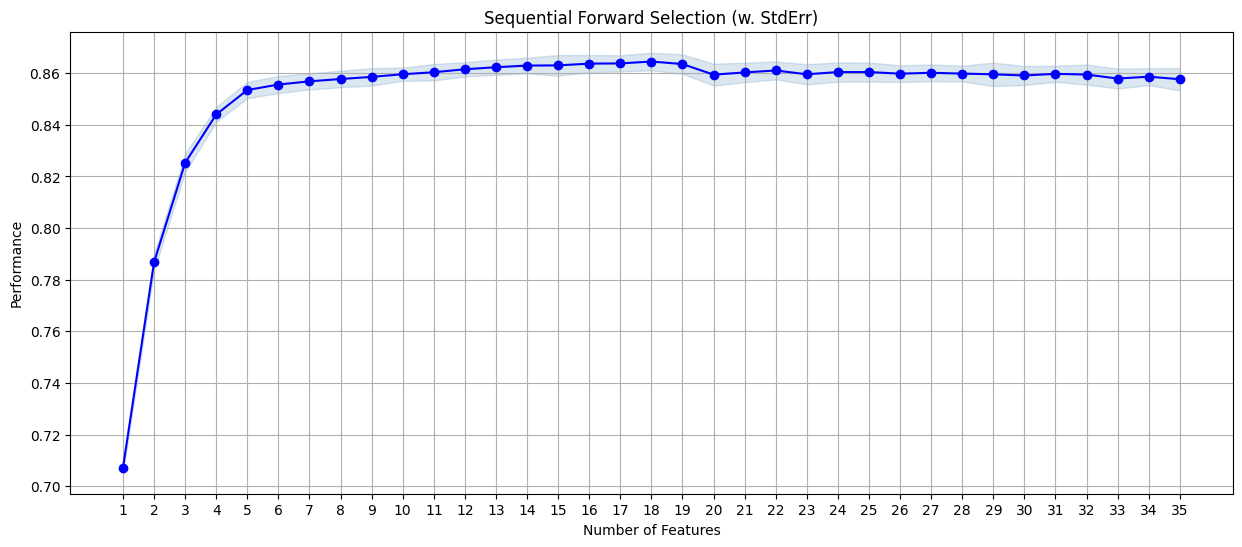

In [35]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [36]:
selected_columns2 = [all_cols[i] for i in 
                     list((0, 3, 5, 6, 10, 12, 13, 14, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32))]

In [37]:
selected_columns2

['h1n1_concern',
 'behavioral_avoidance',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

### Feature selection using CatBoost for seasonal flu

In [38]:
sfs3 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [39]:
sfs3 = sfs3.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\40107588\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warning

In [ ]:
sfdf3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
sfdf3

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.704703565267395, 0.7271142898217366, 0.7135...",0.714989,"(31,)",0.00943423,0.00734015,0.00367008
2,"(0, 31)","[0.7679320011500862, 0.7837448246118458, 0.778...",0.776608,"(0, 31)",0.00663211,0.00516001,0.00258
3,"(0, 22, 31)","[0.8103923231742383, 0.8125849626221966, 0.808...",0.811318,"(0, 22, 31)",0.00287633,0.00223788,0.00111894
4,"(0, 22, 30, 31)","[0.8374371765382405, 0.835688757906843, 0.8293...",0.83481,"(0, 22, 30, 31)",0.00369949,0.00287833,0.00143916
5,"(0, 10, 22, 30, 31)","[0.8448720529039677, 0.8480760494537091, 0.838...",0.844628,"(0, 10, 22, 30, 31)",0.00400366,0.00311499,0.00155749
6,"(0, 10, 22, 30, 31, 32)","[0.8511431857389303, 0.8532162162162161, 0.846...",0.850169,"(0, 10, 22, 30, 31, 32)",0.00298461,0.00232213,0.00116106
7,"(0, 10, 13, 22, 30, 31, 32)","[0.8519936745255894, 0.8555786371477861, 0.847...",0.852078,"(0, 10, 13, 22, 30, 31, 32)",0.00344723,0.00268206,0.00134103
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.8537338987924092, 0.8582610695802186, 0.849...",0.854166,"(0, 10, 13, 22, 26, 30, 31, 32)",0.003782,0.00294252,0.00147126
9,"(0, 10, 13, 22, 26, 29, 30, 31, 32)","[0.85508309373203, 0.8589971247843589, 0.84789...",0.854946,"(0, 10, 13, 22, 26, 29, 30, 31, 32)",0.00481745,0.00374814,0.00187407
10,"(0, 10, 13, 22, 25, 26, 29, 30, 31, 32)","[0.8547544565842438, 0.8601444795859688, 0.848...",0.855745,"(0, 10, 13, 22, 25, 26, 29, 30, 31, 32)",0.00530315,0.00412603,0.00206301


In [ ]:
print(sfdf3.loc[19, 'feature_idx'])

(0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32)


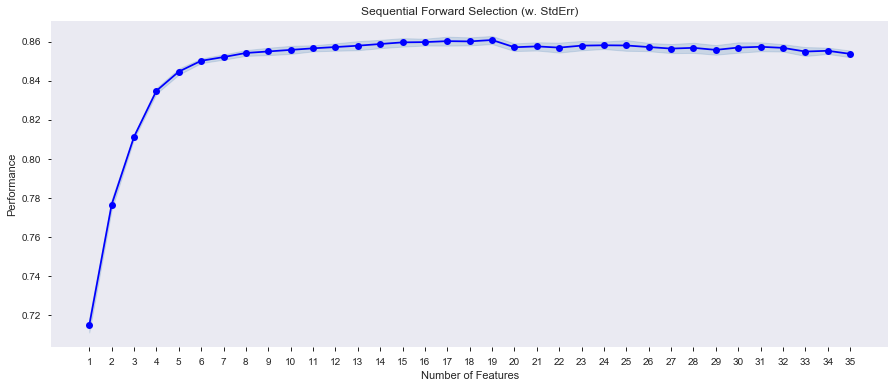

In [ ]:
fig = plot_sfs(sfs3.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
selected_columns3 = [all_cols[i] for i in 
                     list((0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32))]

In [ ]:
selected_columns3

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [ ]:
selected_columns_h1 = selected_columns2
selected_columns_se = selected_columns3

Essentially there seems to be no advantage to make feature selection for `H1N1` while there might be a small improvment, that must be verified, using only 19 columns for `seasonal flu`